# Narrow-Band Test

In [1]:
# Lets implement a Narrowband MVDR... (First the basics)
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchaudio

# Simulation Parameters
c = 343.0  # Speed of sound in m/s
fs = 44000  # Sampling frequency (Hz)
d = 0.1  # Distance between microphones (m)
M = 40  # Number of microphones
T = 2.0  # Duration of signal (s)
n_samples = int(fs * T)
t = torch.arange(n_samples) / fs  # Time axis

In [2]:
# PART1 Signals & Gains
fc = 500

#Partition list
freqs = [fc,fc-25,fc+25,fc-25]
thetas = [-80,-20,30,50]
amps = [5,10,1,15]
target_idx = [1,2]
interf_idx = [0,3]

# Amplitude list
amps_target = [amps[i] for i in target_idx]
amps_interf = [amps[i] for i in interf_idx]

#Freq list
freqs_target = [freqs[i] for i in target_idx]  # Target signal frequency (Hz)
freqs_interf = [freqs[i] for i in interf_idx]  # Interference frequency (Hz)

#Thetas
thetas_target = [thetas[i] for i in target_idx]
thetas_interf = [thetas[i] for i in interf_idx]

#Gain vector
g_target = torch.ones(size=(len(freqs_target),))
g_interf = torch.zeros(size=(len(freqs_interf),))
g = torch.concat((g_target,g_interf))
print(g)

#Sources 
target_signals = [a*torch.sin(2 * torch.pi * f * t) for a,f in zip(amps_target,freqs_target)]
interf_signals = [a*torch.sin(2 * torch.pi * f * t) for a,f in zip(amps_interf,freqs_interf)]

tensor([1., 1., 0., 0.])


In [3]:

def phase2delay(phase,freq):
    """Simple conversion from phase in rad to delay in time"""
    return phase/(2*np.pi*freq)

def compute_delays(theta, M, d, c):
    """Compute time delays for a given angle."""
    # Phase = omega * time_delay = 2*pi*f * time_delay
    theta_rad = torch.deg2rad(torch.tensor(theta))
    delays = (torch.arange(M)-M//2) * d * torch.sin(theta_rad) / c  # Delay per mic
    return delays

# Compute steering vector
def compute_steering_vector(delays, freq):
    """Compute steering vector for one freq (Outputs M)"""
    return torch.exp(-1j * 2 * torch.pi * freq * delays)

def beam_pattern(w,freq):
    theta_scan = torch.linspace(-90, 90, 180)  # Scan angles
    beam_pattern = torch.zeros_like(theta_scan)


    for i, theta in enumerate(theta_scan):
        delays_scan = compute_delays(theta, M, d, c)
        steering_scan = compute_steering_vector(delays_scan, freq)
        power_resp = abs(torch.einsum('M,M->',w.conj(),steering_scan))
        beam_pattern[i] = power_resp

    return beam_pattern

def apply_filter(w,mics,freq):
    # Extract phase and mag
    phase = torch.angle(w)
    mag = torch.abs(w)
    # Assume narrow band and apply the shifts and mag
    delay = phase2delay(phase,freq)
    # Apply the shift and add back up
    M,N= mics.shape
    y = torch.zeros(size=(N,))
    for m in range(M):
        shift = int(delay[m] * fs)
        y += mag[m]*torch.roll(mics[m,:], shift)
    return y

Text(0.5, 0, 'Time (s)')

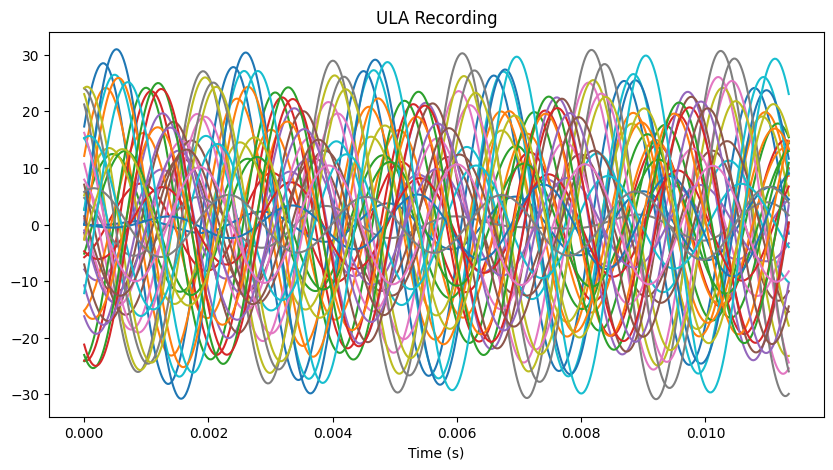

In [4]:
# PART2 Record The Signals

# Compute Delay
target_delays = [compute_delays(theta, M, d, c) for theta in thetas_target]
interf_delays = [compute_delays(theta, M, d, c) for theta in thetas_interf]

# Microphones
mics = torch.zeros((M, n_samples))

for m in range(M):
    # Part 1 : Add targets first
    for i in range(len(target_delays)):
      shift = int(target_delays[i][m] * fs)
      mics[m] += torch.roll(target_signals[i], shift)

    # Part 2 : Add interferences first
    for i in range(len(interf_delays)):
      shift = int(interf_delays[i][m] * fs)
      mics[m] += torch.roll(interf_signals[i], shift)


trange = 500
f,ax = plt.subplots(figsize=(10, 5))
for m in range(M):
  ax.plot(t[:trange],mics[m,:trange],label=str(m))
ax.set_title('ULA Recording')
ax.set_xlabel('Time (s)')

## EVALUATE STEERING VECTOR

In [5]:
# Evaluate stacked steering vectors (M,Ns)
C = [torch.Tensor(compute_steering_vector(delay, f)) for delay,f in zip(target_delays+interf_delays,freqs_target+freqs_interf)]
C = torch.stack(C,dim=-1)

## EVALUATE LCMV FILTER

Text(0.5, 0.98, 'LCMV Filter Coefficient')

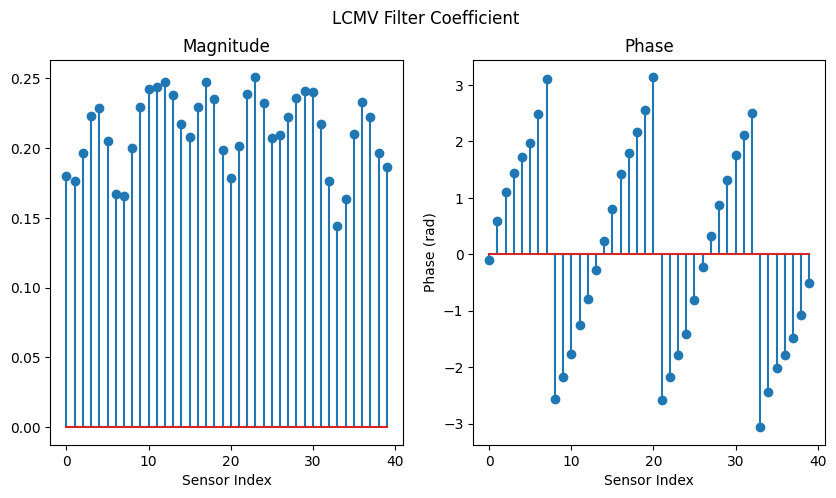

In [6]:
# Step 1 : Covariance and Inverses
N = mics.shape[-1]
Rinv = torch.linalg.pinv(mics @ mics.T.conj()/N)

# Step 2 : Filter
A = Rinv.to(torch.complex64) @ C
B = torch.einsum('NS,NM,MK->SK',C.conj(),Rinv.to(torch.complex64),C)
w = A @ torch.linalg.pinv(B) @ g.to(torch.complex64)

# Plot the Filter responses
f,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].stem(torch.abs(w))
ax[0].set_xlabel('Sensor Index')
ax[0].set_title('Magnitude')

ax[1].stem(torch.angle(w))
ax[1].set_xlabel('Sensor Index')
ax[1].set_ylabel('Phase (rad)')
ax[1].set_title('Phase')

f.suptitle('LCMV Filter Coefficient')

## EVALUATE BEAMPATTERN

/tmp/ipykernel_3873410/3962032022.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_rad = torch.deg2rad(torch.tensor(theta))


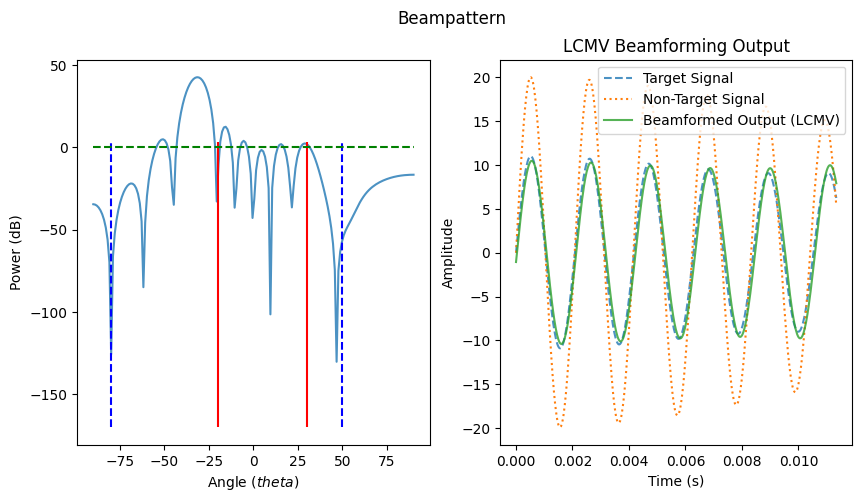

In [7]:
power_lcmv = beam_pattern(w,fc)
y_lcmv= apply_filter(w,mics,fc)

f,ax = plt.subplots(1,2,figsize=(10,5))
f.suptitle('Beampattern')
ax[0].plot(torch.linspace(-90, 90, 180),20*torch.log(power_lcmv),label="Beampattern (MVDR)", alpha=0.8)
for theta in thetas_target:
  ax[0].vlines(theta,ymin=-170,ymax=3,colors='r')

for theta in thetas_interf:
  ax[0].vlines(theta,ymin=-170,ymax=3,colors='b',linestyles='--')
  
ax[0].hlines(0,-90,90,color='g',linestyles='--')
ax[0].set_xlabel('Angle ($theta$)')
ax[0].set_ylabel('Power (dB)')

# Plot
ax[1].plot(t[:trange], sum(target_signals)[:trange], label="Target Signal", linestyle='dashed', alpha=0.8)
ax[1].plot(t[:trange], sum(interf_signals)[:trange], label="Non-Target Signal", linestyle=':')
ax[1].plot(t[:trange], y_lcmv[:trange],  label="Beamformed Output (LCMV)", alpha = 0.8)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("LCMV Beamforming Output")
plt.show()

# Broad-Band Sinusoid Test

# Sample Sinusoid Plot

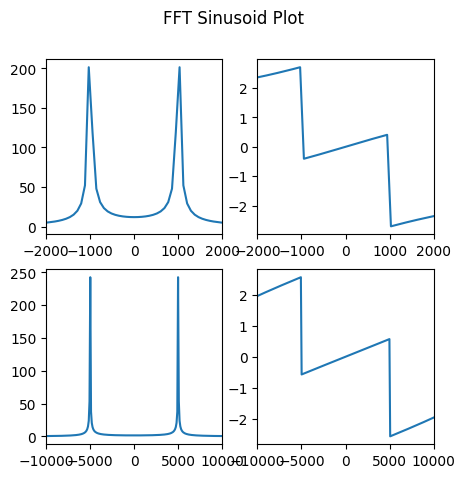

In [9]:
# Try plotting the sinusoid
f1 = 1000
f2 = 5000

y1 = torch.sin(2*torch.pi*f1*t)
y2 = torch.cos(2*torch.pi*f2*t)

f,ax = plt.subplots(2,2,figsize=(5,5))
f.suptitle('FFT Sinusoid Plot')
ax[0,0].plot(faxis,torch.fft.fftshift(abs(torch.fft.fft(y1,Nfft))))
ax[0,1].plot(faxis,torch.fft.fftshift(torch.angle(torch.fft.fft(y1,Nfft))))
for i in range(2):
  ax[0,i].set_xlim([-2*f1,2*f1])

ax[1,0].plot(faxis,torch.fft.fftshift(abs(torch.fft.fft(y2,Nfft))))
ax[1,1].plot(faxis,torch.fft.fftshift(torch.angle(torch.fft.fft(y2,Nfft))))
for i in range(2):
  ax[1,i].set_xlim([-2*f2,2*f2])

# STFT Sample Plot

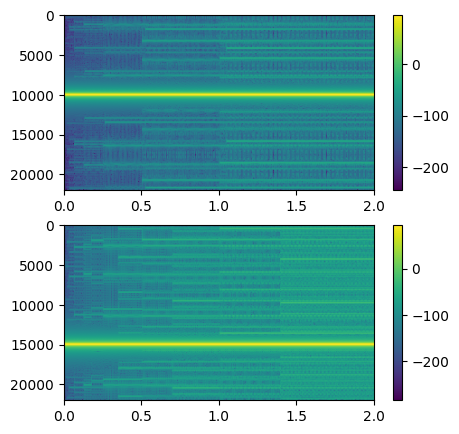

In [10]:
# Try plotting the sinusoid
f1 = 10000
f2 = 15000

y1 = torch.sin(2*torch.pi*f1*t)
y2 = torch.cos(2*torch.pi*f2*t)

# STFT spectrogram
S1 = torch.stft(y1,Nfft,hop_size,win_size,window,return_complex=True)
S2 = torch.stft(y2,Nfft,hop_size,win_size,window,return_complex=True)


# Plot spectrogram
f,ax = plt.subplots(2,1,figsize=(5,5))

img1 = ax[0].imshow(20*torch.log(abs(S1)),extent=[0,T,fs//2,0],aspect='auto')
img2 = ax[1].imshow(20*torch.log(abs(S2)),extent=[0,T,fs//2,0],aspect='auto')
f.colorbar(img1, ax=ax[0])
f.colorbar(img2, ax=ax[1])


# Broadband LCMV

In [250]:
# Lets implement a Narrowband MVDR... (First the basics)
import torch
import matplotlib.pyplot as plt

# Simulation Parameters
c = 343.0  # Speed of sound in m/s
fs = 44000  # Sampling frequency (Hz)
d = 0.01  # Distance between microphones (m)
M = 31  # Number of microphones
T = 2.0  # Duration of signal (s)
n_samples = int(fs * T)
t = torch.arange(n_samples) / fs  # Time axis

# FFT Paramters
Nfft = 512
win_size = Nfft
hop_size = Nfft//2
N = (n_samples+1)//hop_size +1
window = torch.hann_window(win_size)
faxis = torch.fft.fftshift(torch.fft.fftfreq(n = Nfft,d = 1/fs))

## Steering

In [251]:
def compute_delays(theta, M, d, c):
    """Compute time delays for a given angle."""
    # Phase = omega * time_delay = 2*pi*f * time_delay
    theta_rad = torch.deg2rad(torch.tensor(theta))
    delays = (torch.arange(M)-M//2) * d * torch.sin(theta_rad) / c  # Delay per mic
    return delays

# Compute steering vector
def compute_steering_vector(delays):
    """Compute steering vector for one freq (Outputs F,M)"""
    return torch.exp(-1j * 2 * torch.pi * torch.einsum('M,F->FM',delays,faxis[Nfft//2-1:]))


In [281]:
#Partition Source
freqs = [10000,5000,3000]
thetas = [-50,-30,10]
amps = [1,1,1]
target_idx = [1]
interf_idx = [2,0]

# Amplitude list
amps_target = [amps[i] for i in target_idx]
amps_interf = [amps[i] for i in interf_idx]

#Freq list
freqs_target = [freqs[i] for i in target_idx]  # Target signal frequency (Hz)
freqs_interf = [freqs[i] for i in interf_idx]  # Interference frequency (Hz)

#Thetas
thetas_target = [thetas[i] for i in target_idx]
thetas_interf = [thetas[i] for i in interf_idx]

#Gain vector
g_target = torch.ones(size=(len(freqs_target),))
g_interf = torch.zeros(size=(len(freqs_interf),))
g = torch.concat((g_target,g_interf))

#Sources 
target_signals = [a*torch.sin(2 * torch.pi * f * t) for a,f in zip(amps_target,freqs_target)]
interf_signals = [a*torch.sin(2 * torch.pi * f * t) for a,f in zip(amps_interf,freqs_interf)]

print(g)

tensor([1., 0., 0.])


In [282]:
# Compute Delay
target_delays = [compute_delays(theta, M, d, c) for theta in thetas_target]
interf_delays = [compute_delays(theta, M, d, c) for theta in thetas_interf]

# Microphones
mics = torch.zeros((Nfft//2+1,M,N)).to(torch.complex64)

for i in range(len(target_delays)):
  delays = target_delays[i]
  x = target_signals[i]
  s_vec = compute_steering_vector(delays) # M,F
  S = torch.stft(x,Nfft,hop_size,win_size,window,return_complex=True) # Nfft by N
  mics += torch.einsum('FM,FN -> FMN',s_vec,S)

# Part 2 : Add interferences first
for i in range(len(interf_delays)):
  delays = interf_delays[i]
  x = interf_signals[i]
  s_vec = compute_steering_vector(delays) # M
  S = torch.stft(x,Nfft,hop_size,win_size,window,return_complex=True) # Nfft by N
  mics += torch.einsum('FM,FN -> FMN',s_vec,S)

In [283]:
## EVALUATE STEERING VECTOR
# Evaluate stacked steering vectors (F,M,S)
C = [torch.Tensor(compute_steering_vector(delays)) for delays in target_delays+interf_delays] # list of length Ns(S) for sources
C = torch.stack(C,dim=-1) # (F,M,S)

## Evaluate LCMV Filter

In [284]:
# Step 1 : Covariance and Inverses
R = mics@mics.conj().transpose(-1,-2)
Rinv = torch.linalg.pinv(R) # F M M

# Step 2 : Filter
A = Rinv @ C # (F,M,S)
B = torch.einsum('FNS,FNM,FMK->FSK',C.conj(),Rinv.to(torch.complex64),C) # (F,S,S)
w = A @ torch.linalg.pinv(B) @ g.to(torch.complex64)

In [285]:
# Print beam pattern
def beam_pattern(w):
    theta_scan = torch.linspace(-90, 90, 180)  # Scan angles
    beam_pattern = torch.zeros((Nfft//2+1,theta_scan.shape[-1]))

    for i, theta in enumerate(theta_scan):
        delays_scan = compute_delays(theta, M, d, c)
        steering_scan = compute_steering_vector(delays_scan)
        power_resp = abs(torch.einsum('FM,FM->F',w.conj(),steering_scan))
        beam_pattern[:,i] = power_resp

    return beam_pattern

def apply_filter(w,mics):
    # mics (F,M,N)
    # w (F,M)
    return torch.einsum('FMN,FM->FN',mics,w.conj())
    

/tmp/ipykernel_3873410/613900706.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_rad = torch.deg2rad(torch.tensor(theta))


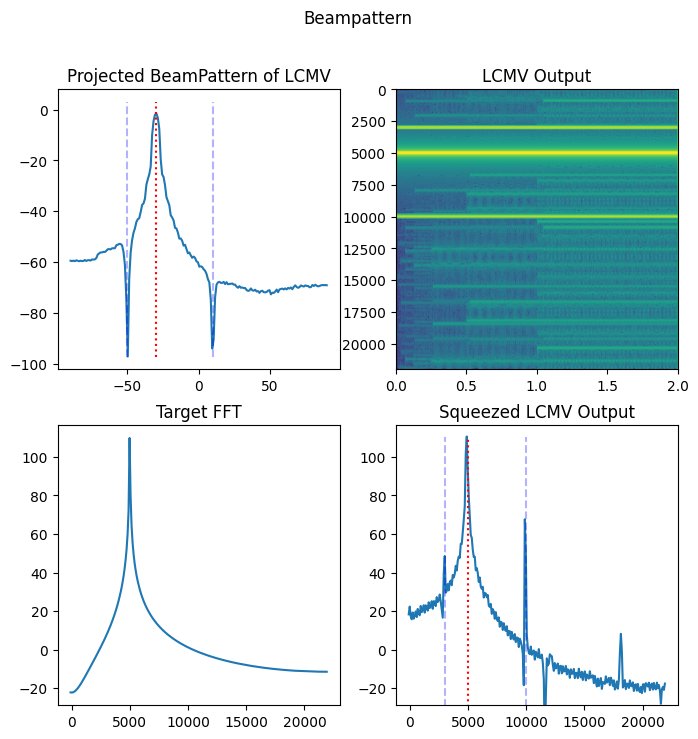

In [286]:
#Beam Pattern 
power_lcmv = beam_pattern(w)

f,ax = plt.subplots(2,2,figsize=(8,8))
f.suptitle('Beampattern')
#ax[0,0].imshow(20*torch.log(power_lcmv),extent=[-90,90,fs//2,0],aspect='auto')
ax[0,0].plot(torch.linspace(-90, 90, 180),20*torch.log(power_lcmv).mean(0))
ax[0,0].set_title('Projected BeamPattern of LCMV')

for theta in thetas_target:
  ax[0,0].vlines(theta,ymin=20*torch.log(power_lcmv).mean(0).min(),ymax=3,colors='r',linestyle=':')

for theta in thetas_interf:
  ax[0,0].vlines(theta,ymin=20*torch.log(power_lcmv).mean(0).min(),ymax=3,colors='b',linestyles='--',alpha=0.3)
#Apply Beamformer

Y = apply_filter(w,mics)

ax[0,1].imshow(20*torch.log(abs(Y)),extent=[0,T,fs//2,0],aspect='auto')
ax[0,1].set_title('LCMV Output')


# FFT of desired source
y_target = sum([torch.fft.fftshift(torch.fft.fft(x,Nfft)) for x in target_signals])
ax[1,0].plot(faxis[Nfft//2-1:],20*torch.log(abs(y_target[Nfft//2-1:])))
ax[1,0].set_title('Target FFT')
ylim = ax[1,0].get_ylim()

# FFT LCMV Output
y = Y.sum(dim=-1)
ax[1,1].plot(faxis[Nfft//2-1:],20*torch.log(abs(y)))
ax[1,1].set_ylim(ylim)
ax[1,1].set_title('Squeezed LCMV Output')
for f in freqs_target:
  ax[1,1].vlines(f,ymin=20*torch.log(abs(y)).min(),ymax=20*torch.log(abs(y)).max(),colors='r',linestyle=':')

for f in freqs_interf:
  ax[1,1].vlines(f,ymin=20*torch.log(abs(y)).min(),ymax=20*torch.log(abs(y)).max(),colors='b',linestyles='--',alpha=0.3)


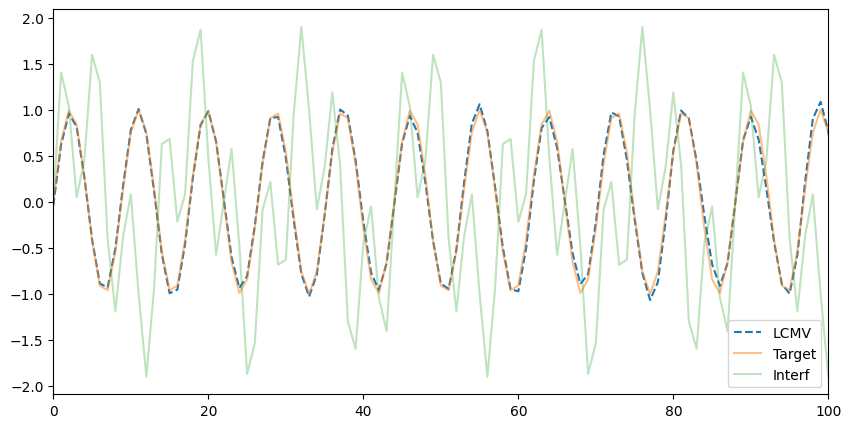

In [287]:
# Plot the signal back
lcmv_output = torch.istft(Y, Nfft, hop_length=hop_size, win_length=win_size, window=window)

f,ax = plt.subplots(figsize=(10,5))
ax.plot(lcmv_output,label='LCMV',linestyle='dashed')

ax.plot(sum(target_signals),label='Target',alpha=0.5)
ax.plot(sum(interf_signals),label='Interf',alpha=0.3)


ax.set_xlim([0,100])


ax.legend()